# Score all profiles and save to csv

In [1]:
# ==== 1) load packages ====
import numpy as np
import pandas as pd
import math
import glob
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import StandardScaler
import torch
import os
import random
random.seed(2025)
os.chdir(
    # "/home/yliu420/Project/Belief-Elicitation-on-LLM-postrelease/analysis"
    "/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis"
)
from analysis_pkg.preprocess import *
from analysis_pkg.models import *
from PCA_TSNE_scoremodel.visualization import *
from llm_belief.analysis import visualize_probability_distribution
torch.manual_seed(2025)

In [2]:
# ==== 2) load training data ====
processes = 10
## load profiles and LLM expectations to profiles and df
fl = [f"../output/{i*1000}_{(i+1)*1000}.csv" for i in range(processes)]
# combine all csv files
df = pd.concat([pd.read_csv(f) for f in fl])
profiles = pd.read_csv("../data/profiles_shuffled.csv")

In [3]:
# ==== 3) preprocess training data ====
## split to Xi and Xj by odd and even rows
X = preprocess(profiles[:2000*processes])
Xi = X[0:2000*processes:2]
Xj = X[1:2000*processes:2]
y = df["profile_id"].apply(lambda x: 1 if x % 2 == 0 else -1)
y = torch.from_numpy(y.values).float()
P, d = Xi.shape

In [4]:
# ==== 4) train model, and calibration ====
split = int(0.9 * P)
ds_tr = PairwiseDataset(Xi[:split], Xj[:split], y[:split])
ds_va = PairwiseDataset(Xi[split:], Xj[split:], y[split:])
dl_tr = DataLoader(ds_tr, batch_size=64, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=0)

## score all profiles

In [5]:
# ==== 5) score all profiles ====
## preprocess all profiles
X_all_profiles = preprocess_test(profiles)
real_profiles = pd.read_csv("../data/real_profiles.csv")
X_real = preprocess_test(real_profiles.iloc[:,:10])

In [6]:
# add profile_id column
profiles['profile_id'] = profiles.index.astype(str)

In [7]:
## score all profiles
torch.manual_seed(2025)
model = MLPScorer(d_in=d, hidden=(256, 128), dropout=0.1)
model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

## calibrate temperature
T = calibrate_temperature(model, dl_va)
print(f"Calibrated Temperature T = {T:.3f}")
all_scores, all_probs = score_profiles(model, X_all_profiles, T)
profiles["MLP_score"] = all_scores
all_scores, all_probs = score_profiles(model, X_real, T)
real_profiles["MLP_score"] = all_scores

[Epoch 01] train_loss=0.4667  val_loss=0.4095
[Epoch 02] train_loss=0.4036  val_loss=0.4027
[Epoch 03] train_loss=0.3936  val_loss=0.3982
[Epoch 04] train_loss=0.3827  val_loss=0.3912
[Epoch 05] train_loss=0.3818  val_loss=0.3979
[Epoch 06] train_loss=0.3726  val_loss=0.3891
[Epoch 07] train_loss=0.3697  val_loss=0.3908
[Epoch 08] train_loss=0.3664  val_loss=0.3993
Calibrated Temperature T = 1.073


In [21]:
# ==== 5) score all profiles ====
model = MLPAttentionScore(d_in=d, hidden=(256, 128), dropout=0.1, n_heads=2)
model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

## calibrate temperature
T = calibrate_temperature(model, dl_va)
print(f"Calibrated Temperature T = {T:.3f}")
## score all profiles
all_scores, all_probs = score_profiles(model, X_all_profiles, T)
profiles["MLP_attention_score"] = all_scores
all_scores, all_probs = score_profiles(model, X_real, T)
real_profiles["MLP_attention_score"] = all_scores

[Epoch 01] train_loss=0.4598  val_loss=0.3780
[Epoch 02] train_loss=0.3721  val_loss=0.3765
[Epoch 03] train_loss=0.3595  val_loss=0.3645
[Epoch 04] train_loss=0.3576  val_loss=0.3626
[Epoch 05] train_loss=0.3528  val_loss=0.3700
[Epoch 06] train_loss=0.3522  val_loss=0.3633
Calibrated Temperature T = 1.083


In [ ]:
torch.manual_seed(2025)
model = LogisticRegression(d_in=d)
model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

## calibrate temperature
T = calibrate_temperature(model, dl_va)
print(f"Calibrated Temperature T = {T:.3f}")
## score all profiles
all_scores, all_probs = score_profiles(model, X_all_profiles, T)
profiles["Logistic_regression_score"] = all_scores
all_scores, all_probs = score_profiles(model, X_real, T)
real_profiles["Logistic_regression_score"] = all_scores

[Epoch 01] train_loss=0.6710  val_loss=0.6235
[Epoch 02] train_loss=0.6055  val_loss=0.5807
[Epoch 03] train_loss=0.5669  val_loss=0.5554
[Epoch 04] train_loss=0.5423  val_loss=0.5383
[Epoch 05] train_loss=0.5248  val_loss=0.5255
[Epoch 06] train_loss=0.5112  val_loss=0.5144
[Epoch 07] train_loss=0.5001  val_loss=0.5054
[Epoch 08] train_loss=0.4908  val_loss=0.4973
[Epoch 09] train_loss=0.4826  val_loss=0.4904
[Epoch 10] train_loss=0.4757  val_loss=0.4843
[Epoch 11] train_loss=0.4697  val_loss=0.4791
[Epoch 12] train_loss=0.4645  val_loss=0.4743
[Epoch 13] train_loss=0.4600  val_loss=0.4706
[Epoch 14] train_loss=0.4561  val_loss=0.4673
[Epoch 15] train_loss=0.4527  val_loss=0.4644
[Epoch 16] train_loss=0.4497  val_loss=0.4618
[Epoch 17] train_loss=0.4471  val_loss=0.4597
[Epoch 18] train_loss=0.4450  val_loss=0.4578
[Epoch 19] train_loss=0.4431  val_loss=0.4564
[Epoch 20] train_loss=0.4415  val_loss=0.4551
Calibrated Temperature T = 0.829


In [ ]:
# # ==== 6) save scored profiles ====
# profiles.to_csv("../data/scored_profiles_shuffled.csv", index=False)
# real_profiles.to_csv("../data/scored_real_profiles.csv", index=False)

## score by LLM compare (fix real)

In [30]:
real_profiles = pd.read_csv("../data/real_profiles.csv")
for real_model in real_profiles['real model'].unique():
    df_realfix = pd.read_csv(f"../output/{real_model}_all_makeup_profiles.csv")
    df_top50 = pd.read_csv(f"../output/{real_model}_ntop50.csv")
    print(f"{real_model}: {df_realfix['chosen_id'].value_counts().get(real_model, 0)}/{len(df_realfix)}; {df_top50['chosen_id'].value_counts().get(real_model, 0)}/{len(df_top50)}")

iPhone 16: 298/300; 38/50
iPhone 16 Plus: 300/300; 39/50
iPhone 16 Pro: 300/300; 45/50
iPhone 16 Pro Max: 296/300; 34/50
iPhone 17: 295/300; 26/50
iPhone 17 Air: 130/300; 0/50
iPhone 17 Pro: 267/300; 9/50
iPhone 17 Pro Max: 242/300; 4/50


## rank real profiles over top 100 made-up profiles (direct method/MLP/MLP_attention/LR)

In [43]:
for real_model in real_profiles['profile_id'][:4]:
    direct_df = pd.read_csv(f"../output/{real_model}_ntop100.csv")

In [24]:
# # load real profiles
# df_real = rearrange_dataframe(pd.read_csv("../data/scored_real_profiles.csv"))
# profile_real = df_real[df_real["profile_id"] == real_profile_id].iloc[0, :10].to_dict()
# logging.info(f"Compared with real specs from {real_profile_id}.")
# # resample n_makeup profiles
# profiles = pd.read_csv("../data/scored_profiles_shuffled.csv")
# profiles_sorted = profiles[:20000].sort_values(by="MLP_score").reset_index(drop=True) # default as ascending order
# profiles_sorted = profiles_sorted[:,:10]  # only keep attribute columns

In [46]:
profiles_top100 = pd.read_csv("../data/scored_profiles_shuffled.csv")[:20000].sort_values('MLP_score', ascending=False).head(100)
mlp100 = profiles_top100['MLP_score'].values
mlpattn100 = profiles_top100['MLP_attention_score'].values
lr100 = profiles_top100['Logistic_regression_score'].values
real_profiles = pd.read_csv("../data/scored_real_profiles.csv")
for index, row in real_profiles.iterrows():
    if index >= 4:
        break
    real_model = row['profile_id']
    direct_df = pd.read_csv(f"../output/{real_model}_ntop100.csv")
    rank = 101 - direct_df['chosen_id'].value_counts().get(real_model, 0)
    print(f"{real_model} & {rank}/101 & {np.sum(mlp100 > row['MLP_score'])+1}/101 & {np.sum(mlpattn100 > row['MLP_attention_score'])+1}/101 & {np.sum(lr100 > row['Logistic_regression_score'])+1}/101 \\\\")

iPhone 16 & 12/101 & 13/101 & 10/101 & 15/101 \\
iPhone 16 Plus & 7/101 & 58/101 & 16/101 & 56/101 \\
iPhone 16 Pro & 9/101 & 7/101 & 5/101 & 22/101 \\
iPhone 16 Pro Max & 16/101 & 38/101 & 40/101 & 71/101 \\


## train all three models and score resample 300, top 50 and real profils

In [60]:
split = int(0.9 * P)
ds_tr = PairwiseDataset(Xi[:split], Xj[:split], y[:split])
ds_va = PairwiseDataset(Xi[split:], Xj[split:], y[split:])
dl_tr = DataLoader(ds_tr, batch_size=64, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=0)

profiles = pd.read_csv("../data/scored_profiles_shuffled.csv")
profiles_sorted = profiles[:20000].sort_values(by="score").reset_index(drop=True)
bin_size = 20000 // 100
profiles_rf = pd.DataFrame()
profiles_top50 = profiles_sorted[-50:]
for shift in [-25, 0, 25]:  # -25, 0, 25
    sampled = profiles_sorted.iloc[bin_size // 2 + shift :: bin_size]  # 从索引bin_size//2+shift开始，每隔bin_size行取1行
    profiles_rf = pd.concat([profiles_rf, sampled], ignore_index=True)

In [ ]:
torch.manual_seed(2025)
model = MLPScorer(d_in=d, hidden=(256, 128), dropout=0.1)
model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

## calibrate temperature
T = calibrate_temperature(model, dl_va)
print(f"Calibrated Temperature T = {T:.3f}")
fea_cols = profiles_rf.columns[:10]
X_rf = preprocess_test(profiles_rf[fea_cols])
X_top50 = preprocess_test(profiles_top50[fea_cols])
X_real = preprocess_test(real_profiles[fea_cols])
## score all profiles
scores, _ = score_profiles(model, X_rf, T)
profiles_rf["MLP_score"] = scores

scores, _ = score_profiles(model, X_top50, T)
profiles_top50["MLP_score"] = scores

scores, _ = score_profiles(model, X_real, T)
real_profiles["MLP_score"] = scores

[Epoch 01] train_loss=0.4667  val_loss=0.4095
[Epoch 02] train_loss=0.4036  val_loss=0.4027
[Epoch 03] train_loss=0.3936  val_loss=0.3982
[Epoch 04] train_loss=0.3827  val_loss=0.3912
[Epoch 05] train_loss=0.3818  val_loss=0.3979
[Epoch 06] train_loss=0.3726  val_loss=0.3891
[Epoch 07] train_loss=0.3697  val_loss=0.3908
[Epoch 08] train_loss=0.3664  val_loss=0.3993
Calibrated Temperature T = 1.073


/var/folders/kd/bfykm6ds1jg2trz545lw7lnw0000gn/T/ipykernel_7735/2014520262.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_top50["MLP_score"] = scores


In [62]:
torch.manual_seed(2025)
model = MLPAttentionScore(d_in=d, hidden=(256, 128), dropout=0.1)
model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

## calibrate temperature
T = calibrate_temperature(model, dl_va)
print(f"Calibrated Temperature T = {T:.3f}")

X_rf = preprocess_test(profiles_rf[fea_cols])
X_top50 = preprocess_test(profiles_top50[fea_cols])
X_real = preprocess_test(real_profiles[fea_cols])
## score all profiles
scores, _ = score_profiles(model, X_rf, T)
profiles_rf["MLP_attention_score"] = scores

scores, _ = score_profiles(model, X_top50, T)
profiles_top50["MLP_attention_score"] = scores

scores, _ = score_profiles(model, X_real, T)
real_profiles["MLP_attention_score"] = scores

[Epoch 01] train_loss=0.4459  val_loss=0.4065
[Epoch 02] train_loss=0.3691  val_loss=0.3730
[Epoch 03] train_loss=0.3591  val_loss=0.3667
[Epoch 04] train_loss=0.3526  val_loss=0.3837
[Epoch 05] train_loss=0.3501  val_loss=0.3777
Calibrated Temperature T = 0.958


/var/folders/kd/bfykm6ds1jg2trz545lw7lnw0000gn/T/ipykernel_7735/335056625.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_top50["MLP_attention_score"] = scores


In [63]:
torch.manual_seed(2025)
model = LogisticRegression(d_in=d)
model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

## calibrate temperature
T = calibrate_temperature(model, dl_va)
print(f"Calibrated Temperature T = {T:.3f}")

X_rf = preprocess_test(profiles_rf[fea_cols])
X_top50 = preprocess_test(profiles_top50[fea_cols])
X_real = preprocess_test(real_profiles[fea_cols])
## score all profiles
scores, _ = score_profiles(model, X_rf, T)
profiles_rf["Logistic_regression_score"] = scores

scores, _ = score_profiles(model, X_top50, T)
profiles_top50["Logistic_regression_score"] = scores

scores, _ = score_profiles(model, X_real, T)
real_profiles["Logistic_regression_score"] = scores

[Epoch 01] train_loss=0.6710  val_loss=0.6235
[Epoch 02] train_loss=0.6055  val_loss=0.5807
[Epoch 03] train_loss=0.5669  val_loss=0.5554
[Epoch 04] train_loss=0.5423  val_loss=0.5383
[Epoch 05] train_loss=0.5248  val_loss=0.5255
[Epoch 06] train_loss=0.5112  val_loss=0.5144
[Epoch 07] train_loss=0.5001  val_loss=0.5054
[Epoch 08] train_loss=0.4908  val_loss=0.4973
[Epoch 09] train_loss=0.4826  val_loss=0.4904
[Epoch 10] train_loss=0.4757  val_loss=0.4843
[Epoch 11] train_loss=0.4697  val_loss=0.4791
[Epoch 12] train_loss=0.4645  val_loss=0.4743
[Epoch 13] train_loss=0.4600  val_loss=0.4706
[Epoch 14] train_loss=0.4561  val_loss=0.4673
[Epoch 15] train_loss=0.4527  val_loss=0.4644
[Epoch 16] train_loss=0.4497  val_loss=0.4618
[Epoch 17] train_loss=0.4471  val_loss=0.4597
[Epoch 18] train_loss=0.4450  val_loss=0.4578
[Epoch 19] train_loss=0.4431  val_loss=0.4564
[Epoch 20] train_loss=0.4415  val_loss=0.4551
Calibrated Temperature T = 0.829


/var/folders/kd/bfykm6ds1jg2trz545lw7lnw0000gn/T/ipykernel_7735/43361375.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_top50["Logistic_regression_score"] = scores


## print table

In [31]:
profiles_index = pd.read_csv("../data/index_only_scored_profiles_shuffled.csv")
profiles_sorted = profiles_index[:20000].sort_values(by="score")
profiles_sorted = profiles.loc[profiles_sorted.index,:].reset_index(drop=True)
bin_size = 20000 // 100
profiles_rf = pd.DataFrame()
profiles_top50 = profiles_sorted[-50:]
for shift in [-25, 0, 25]:  # -25, 0, 25
    sampled = profiles_sorted.iloc[bin_size // 2 + shift :: bin_size]  # 从索引bin_size//2+shift开始，每隔bin_size行取1行
    profiles_rf = pd.concat([profiles_rf, sampled], ignore_index=True)

In [32]:
## print table
for real_model in real_profiles['real model'].unique():
    print(real_model, end=" & ")
    df_realfix = pd.read_csv(f"../output/{real_model}_all_makeup_profiles.csv")
    print(f"{df_realfix['chosen_id'].value_counts().get(real_model, 0)/len(df_realfix)*100:.2f}\%", end =" & ")
    for score_type in ['MLP_score', 'MLP_attention_score', 'Logistic_regression_score']:
        score = real_profiles[real_profiles['real model'] == real_model][score_type].mean()
        fr_scores = profiles_rf[score_type]
        count = np.sum(fr_scores < score)
        if score_type=='Logistic_regression_score':
            print(f"{count/3:.2f}\%", end=" \\\\ \n ")
        else:
            print(f"{count/3:.2f}\%", end=" & ")

iPhone 16 & 99.33\% & 100.00\% & 100.00\% & 99.33\% \\ 
 iPhone 16 Plus & 100.00\% & 100.00\% & 100.00\% & 92.67\% \\ 
 iPhone 16 Pro & 100.00\% & 100.00\% & 100.00\% & 98.00\% \\ 
 iPhone 16 Pro Max & 98.67\% & 100.00\% & 100.00\% & 89.00\% \\ 
 iPhone 17 & 98.33\% & 99.33\% & 100.00\% & 95.00\% \\ 
 iPhone 17 Air & 43.33\% & 36.00\% & 35.00\% & 32.33\% \\ 
 iPhone 17 Pro & 89.00\% & 96.67\% & 98.00\% & 92.67\% \\ 
 iPhone 17 Pro Max & 80.67\% & 94.33\% & 94.33\% & 78.33\% \\ 
 

In [33]:
## print table
for real_model in real_profiles['real model'].unique():
    print(real_model, end=" & ")
    df_top50 = pd.read_csv(f"../output/{real_model}_ntop50.csv")
    print(f"{df_top50['chosen_id'].value_counts().get(real_model, 0)/len(df_top50)*100:.2f}\%", end =" & ")
    for score_type in ['MLP_score', 'MLP_attention_score', 'Logistic_regression_score']:
        score = real_profiles[real_profiles['real model'] == real_model][score_type].mean()
        t50_scores = profiles_top50[score_type]
        count = np.sum(t50_scores < score)
        if score_type=='Logistic_regression_score':
            print(f"{count*2:.2f}\%", end=" \\\\ \n ")
        else:
            print(f"{count*2:.2f}\%", end=" & ")

iPhone 16 & 76.00\% & 76.00\% & 80.00\% & 82.00\% \\ 
 iPhone 16 Plus & 78.00\% & 36.00\% & 70.00\% & 36.00\% \\ 
 iPhone 16 Pro & 90.00\% & 88.00\% & 90.00\% & 76.00\% \\ 
 iPhone 16 Pro Max & 68.00\% & 50.00\% & 58.00\% & 24.00\% \\ 
 iPhone 17 & 52.00\% & 2.00\% & 62.00\% & 62.00\% \\ 
 iPhone 17 Air & 0.00\% & 0.00\% & 0.00\% & 0.00\% \\ 
 iPhone 17 Pro & 18.00\% & 0.00\% & 10.00\% & 36.00\% \\ 
 iPhone 17 Pro Max & 8.00\% & 0.00\% & 0.00\% & 2.00\% \\ 
 

# Plot distribution of scores

In [81]:
real_profiles[['real model','MLP_score']]

,real model,MLP_score
0,iPhone 16,1.205598
1,iPhone 16 Plus,0.882192
2,iPhone 16 Pro,1.343866
3,iPhone 16 Pro Max,0.940251
4,iPhone 17,0.561737
5,iPhone 17 Air,-4.137487
6,iPhone 17 Pro,0.165168
7,iPhone 17 Pro Max,-0.052619


Mean: -3.30
Median: -3.27
Std: 1.96
Variance: 3.86


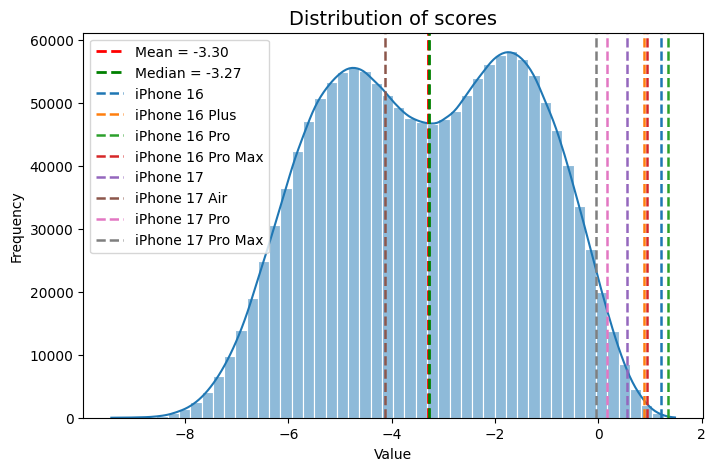

In [82]:
# ==== extra) draw the distribution of scores ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
profiles = pd.read_csv("../data/scored_profiles_shuffled.csv")
arr = profiles["score"].values

mean = np.mean(arr)
median = np.median(arr)
std = np.std(arr)
var = np.var(arr)
skew = sns.utils.axlabel  

print(f"Mean: {mean:.2f}")
print(f"Median: {median:.2f}")
print(f"Std: {std:.2f}")
print(f"Variance: {var:.2f}")

# histgram with KDE
plt.figure(figsize=(8,5))
sns.histplot(arr, bins=50, kde=True, edgecolor='white')

# add vertical lines for mean and median
plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.2f}')
plt.axvline(median, color='green', linestyle='--', linewidth=2, label=f'Median = {median:.2f}')

# add color for real profiles' scores
colors = sns.color_palette("tab10", 8)   # 自动生成8种协调颜色，可改为 "husl", "Set2", "Paired" 等调色板

for i in range(8):
    plt.axvline(real_profiles.loc[i, 'MLP_score'], color=colors[i], linestyle='--', linewidth=1.8, label=real_profiles.loc[i, 'real model'])

plt.title("Distribution of scores", fontsize=14)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Mean: -0.13
Median: -0.07
Std: 1.97
Variance: 3.89


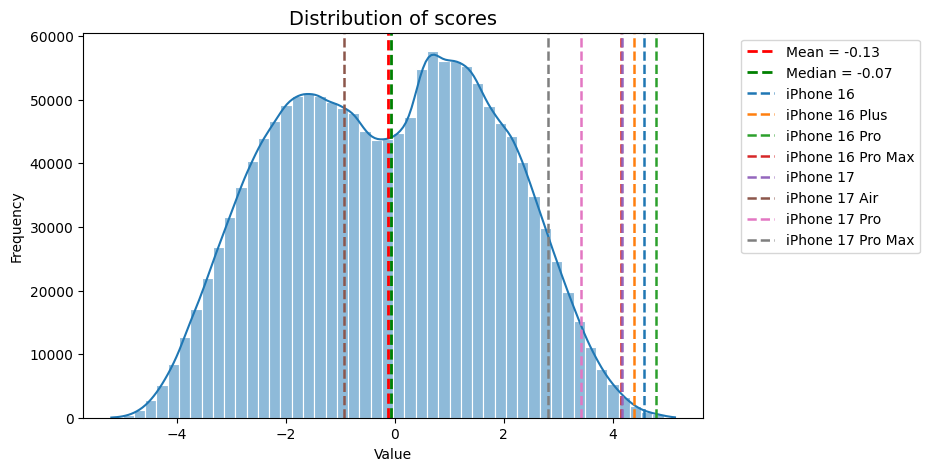

In [37]:
# ==== extra) draw the distribution of scores (MLP Attention) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
profiles = pd.read_csv("../data/scored_profiles_shuffled.csv")
arr = profiles["MLP_attention_score"].values

mean = np.mean(arr)
median = np.median(arr)
std = np.std(arr)
var = np.var(arr)
skew = sns.utils.axlabel  

print(f"Mean: {mean:.2f}")
print(f"Median: {median:.2f}")
print(f"Std: {std:.2f}")
print(f"Variance: {var:.2f}")

# histgram with KDE
plt.figure(figsize=(8,5))
sns.histplot(arr, bins=50, kde=True, edgecolor='white')

# add vertical lines for mean and median
plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.2f}')
plt.axvline(median, color='green', linestyle='--', linewidth=2, label=f'Median = {median:.2f}')

# add color for real profiles' scores
colors = sns.color_palette("tab10", 8)   # 自动生成8种协调颜色，可改为 "husl", "Set2", "Paired" 等调色板

for i in range(8):
    plt.axvline(real_profiles.loc[i, 'MLP_attention_score'], color=colors[i], linestyle='--', linewidth=1.8, label=real_profiles.loc[i, 'real model'])

plt.title("Distribution of scores", fontsize=14)
plt.xlabel("Value")
plt.ylabel("Frequency")
# plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.show()


Mean: -0.77
Median: -0.77
Std: 1.19
Variance: 1.42


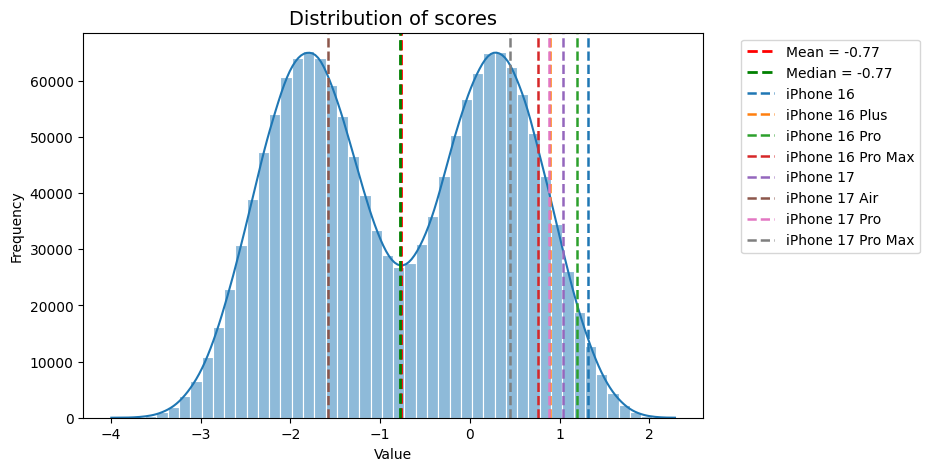

In [38]:
# ==== extra) draw the distribution of scores (MLP Attention) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
profiles = pd.read_csv("../data/scored_profiles_shuffled.csv")
arr = profiles["Logistic_regression_score"].values

mean = np.mean(arr)
median = np.median(arr)
std = np.std(arr)
var = np.var(arr)
skew = sns.utils.axlabel  

print(f"Mean: {mean:.2f}")
print(f"Median: {median:.2f}")
print(f"Std: {std:.2f}")
print(f"Variance: {var:.2f}")

# histgram with KDE
plt.figure(figsize=(8,5))
sns.histplot(arr, bins=50, kde=True, edgecolor='white')

# add vertical lines for mean and median
plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.2f}')
plt.axvline(median, color='green', linestyle='--', linewidth=2, label=f'Median = {median:.2f}')

# add color for real profiles' scores
colors = sns.color_palette("tab10", 8)   # 自动生成8种协调颜色，可改为 "husl", "Set2", "Paired" 等调色板

for i in range(8):
    plt.axvline(real_profiles.loc[i, 'Logistic_regression_score'], color=colors[i], linestyle='--', linewidth=1.8, label=real_profiles.loc[i, 'real model'])

plt.title("Distribution of scores", fontsize=14)
plt.xlabel("Value")
plt.ylabel("Frequency")
# plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.show()


# Resample N profiles by the distribution 

In [12]:
profiles[:20000]

,battery life (in hours of video playback),screen size (in inches),thickness (in mm),front camera resolution (in MP),rear camera main lens resolution (in MP),rear camera longest focal length (in x),ultrawide camera,Geekbench multicore score,RAM,price,score
0,25.0,6.3,8.78,30.0,36.0,5.0,equipped,8642.0,8,1149.0,-0.539467
1,36.0,6.6,8.16,17.0,29.0,1.0,equipped,6119.0,4,1037.0,-1.896450
2,24.0,6.9,8.80,18.0,34.0,10.0,equipped,7766.0,12,1249.0,-1.926772
3,20.0,6.6,8.80,13.0,72.0,1.0,not equipped,9698.0,4,1075.0,-4.235240
4,43.0,6.3,7.70,12.0,38.0,4.9,equipped,9560.0,4,1249.0,-0.363897
...,...,...,...,...,...,...,...,...,...,...,...
19995,24.0,6.1,7.70,18.0,72.0,7.7,not equipped,8600.0,16,1031.0,-5.394857
19996,18.0,6.3,8.30,12.0,35.0,8.0,equipped,9370.0,12,1149.0,0.147291
19997,18.0,6.3,8.13,12.0,60.0,10.0,not equipped,6370.0,4,1221.0,-4.635051
19998,18.0,6.6,7.70,18.0,48.0,5.0,not equipped,8600.0,16,1249.0,-4.047519


In [15]:
profiles_sorted = profiles[:20000].sort_values(by="score").reset_index(drop=True)
sampled = profiles_sorted.iloc[100::200]  # 从索引2开始，每隔200行取1行
sampled

,battery life (in hours of video playback),screen size (in inches),thickness (in mm),front camera resolution (in MP),rear camera main lens resolution (in MP),rear camera longest focal length (in x),ultrawide camera,Geekbench multicore score,RAM,price,score
100,36.0,6.9,5.93,30.0,62.0,1.0,not equipped,6116.0,16,1068.0,-7.583773
300,24.0,6.6,8.70,24.0,72.0,8.0,not equipped,6401.0,16,1172.0,-7.099877
500,36.0,6.3,6.00,18.0,74.0,1.0,not equipped,6965.0,4,949.0,-6.841104
700,41.0,6.3,6.00,23.0,72.0,1.1,not equipped,9585.0,16,927.0,-6.638832
900,27.0,6.1,6.13,30.0,48.0,9.9,not equipped,5982.0,16,1172.0,-6.496635
...,...,...,...,...,...,...,...,...,...,...,...
19100,29.0,6.6,9.06,12.0,60.0,2.9,equipped,6200.0,8,1149.0,-0.201878
19300,41.0,6.6,8.68,18.0,60.0,5.1,equipped,9422.0,8,849.0,-0.072344
19500,42.0,6.1,7.72,18.0,53.0,8.0,equipped,8472.0,12,933.0,0.090829
19700,24.0,6.3,6.28,13.0,48.0,8.0,equipped,8517.0,8,862.0,0.260944


<Axes: xlabel='score', ylabel='Count'>

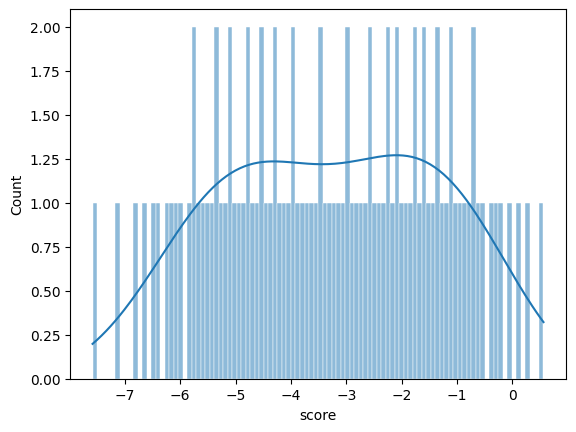

In [17]:
sns.histplot(sampled['score'], bins=100, kde=True, edgecolor='white')